In [ ]:
# 03_spatial-modeling.ipynb
# Performs spatial econometric modeling on NYC census tracts.

# Libraries
import sys
import pickle
import time
import joblib
import random
import libpysal as lps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from esda.moran import Moran
from splot.esda import moran_scatterplot
from libpysal.weights import KNN, Queen, DistanceBand
from sklearn.preprocessing import StandardScaler
from spreg import GM_Error
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


sys.path.append(str(Path().resolve().parent / "src"))
from cleaning_functions import preview_df

# Paths
DATA_DIR = Path("../data/modeling/")
GDF_PATH = DATA_DIR / "gdf_tracts.pkl"

In [ ]:
# == Load data ===
with open(GDF_PATH, "rb") as f:
    tracts = pickle.load(f)

tracts = tracts.set_crs("EPSG:2263")

In [ ]:
# =============================================
# Enhanced Feature Engineering
# =============================================

# Copy source data
analysis_df = tracts.copy()

# -------------------------------
# Log Transformations
# -------------------------------
log_transform_vars = [
    "median_rent",
    "population",
    "eviction_rate_per_1000",
]
for var in log_transform_vars:
    analysis_df[f"log_{var}"] = np.log1p(analysis_df[var])

# Log population density
analysis_df["log_pop_density"] = np.log1p(
    analysis_df["population"] / analysis_df["geometry"].area
)

# Rename column
analysis_df = analysis_df.rename(columns={"log_median_rent": "log_rent"})

# -------------------------------
# Temporal Lags (3-Year Window)
# -------------------------------
lag_vars = [
    "log_rent",
    "has_resilience_project",
    "poverty_rate",
    "edu_college_plus_share",
    "race_white_share",
    "population",
    "eviction_rate_per_1000",
]
analysis_df = analysis_df.sort_values(["GEOID", "year"])
for lag in [1, 2, 3]:
    for var in lag_vars:
        colname = (
            f"{var}_lag_{lag}" if not var.startswith("log_") else f"{var}_lag_{lag}"
        )
        analysis_df[colname] = analysis_df.groupby("GEOID")[var].shift(lag)

# -------------------------------
# Spatial Interaction Terms
# -------------------------------
treatment = analysis_df["has_resilience_project"]

interaction_terms = {
    "coastal_treated": analysis_df["onenyc_Coastal Defense"],
    "eviction_pressure_treated": analysis_df["eviction_rate_per_1000"],
    "no_diploma_treated": analysis_df["edu_no_diploma_share"],
    "density_treated": analysis_df["log_pop_density"],
}

for name, variable in interaction_terms.items():
    if name in ["projval_poverty_treated", "projval_white_treated"]:
        analysis_df[name] = variable  # already combined
    else:
        analysis_df[name] = variable * treatment
# Convert coordinates to State Plane (meters) for accurate distances
analysis_df = analysis_df.to_crs(epsg=2263).copy()  # NY State Plane

# Create Queen weights and automatically keep largest component
final_weights = Queen.from_dataframe(analysis_df, use_index=False)
final_weights.transform = "r"  # Row-standardize

# Use the correct subset of data that matches the weights matrix
analysis_df_subset = analysis_df.copy()  

spatial_lag_vars = [
    "log_rent",
    "poverty_rate",
    "coastal_treated",
    "log_pop_density",
    "edu_no_diploma_share",
]

for var in spatial_lag_vars:
    analysis_df_subset[f"W_{var}"] = lps.weights.lag_spatial(
        final_weights, analysis_df_subset[var]
    )

In [ ]:
# =============================================
# KNN Imputation
# =============================================

# -------------------------------
# Preprocessing for Imputation
# -------------------------------

# Select numeric columns (excluding IDs, geometry, and categoricals)
numeric_cols = analysis_df_subset.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = [
    "GEOID",
    "year",
    "has_resilience_project",
    "geometry"
]

impute_cols = [col for col in numeric_cols if col not in exclude_cols]

# Create a copy for imputation
analysis_df_imputed = analysis_df_subset.copy()

# -------------------------------
# KNN Imputation
# -------------------------------

# Initialize imputer (k=5 neighbors, weighted by distance)
imputer = KNNImputer(n_neighbors=5, weights="distance")

# Impute missing values
analysis_df_imputed[impute_cols] = imputer.fit_transform(
    analysis_df_subset[impute_cols]
)

In [ ]:
# =============================================
# Normalization
# =============================================

def standardize_float_columns(df):
    """
    Standardize all float64 columns in the DataFrame using z-score normalization.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing columns to standardize.

    Returns
    -------
    pandas.DataFrame
        DataFrame with float64 columns standardized (mean=0, std=1).
    """
    df_copy = df.copy()

    # Select only float columns (exclude geometry, int, bool, etc.)
    float_cols = df_copy.select_dtypes(include=["float64"]).columns

    # Standardize
    scaler = StandardScaler()
    df_copy[float_cols] = scaler.fit_transform(df_copy[float_cols])

    return df_copy


# Apply
analysis_df_standardized = standardize_float_columns(analysis_df_imputed)

In [ ]:
# =============================================
# Multicollinearity Evaluation
# =============================================

X_vars = [
    # === Treatment and Exposure (core only, drop collinear raw vars) ===
    "has_resilience_project",
    "proj_count",
    "post_project_lag1",
    "post_project_lag2",
    "post_project_lag3",
    "post_project_lag4",
    "post_project_lag5",
    # === Displacement Outcomes ===
    "log_eviction_rate_per_1000",
    "high_eviction_year",
    # === Demographic Context (log versions only) ===
    "log_pop_density",
    "log_population",
    "edu_college_plus_share",
    "edu_no_diploma_share",
    # === Temporal Lags ===
    "log_rent_lag_1",
    "log_rent_lag_2",
    "log_rent_lag_3",
    "poverty_rate_lag_1",
    "poverty_rate_lag_2",
    "poverty_rate_lag_3",
    "edu_college_plus_share_lag_1",
    "edu_college_plus_share_lag_2",
    "edu_college_plus_share_lag_3",
    "race_white_share_lag_1",
    "race_white_share_lag_2",
    "race_white_share_lag_3",
    "population_lag_1",
    "population_lag_2",
    "population_lag_3",
    "eviction_rate_per_1000_lag_1",
    "eviction_rate_per_1000_lag_2",
    "eviction_rate_per_1000_lag_3",
    # === Interaction Terms (keep treated, drop raw source vars) ===
    "coastal_treated",
    "eviction_pressure_treated",
    "no_diploma_treated",
    "density_treated",
    # === Spatial Lags (moderated set) ===
    "W_log_rent",
    "W_poverty_rate",
    "W_coastal_treated",
    "W_log_pop_density",
    "W_edu_no_diploma_share"
]

X_df = analysis_df_standardized[X_vars].dropna()
X_df = X_df.select_dtypes(include=["number"]).astype(float)
X_vif = add_constant(X_df)

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

print(vif_data.sort_values(by="VIF", ascending=False).head(10))

In [ ]:
# =============================================
# Corrected Spatial Error Model Implementation
# =============================================

def run_spatial_error_model(
    df,
    X_vars,
    y_var="log_rent",
    weights_method="queen",
    weights_params=None,
    add_year_fe=True,
):
    """
    Fit a Spatial Error Model (SEM) using PySAL's GM_Error estimator.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing geometry and variables.
    X_vars : list of str
        Names of explanatory variables to include in the model.
    y_var : str, default 'log_rent'
        Name of the dependent variable.
    weights_method : {'queen', 'knn', 'distance'}, default 'queen'
        Method for constructing the spatial weights matrix.
        - 'queen': Queen contiguity weights.
        - 'knn': k-nearest neighbors weights (requires 'k' in weights_params).
        - 'distance': Distance band weights (requires 'threshold' in weights_params).
    weights_params : dict or None, optional
        Additional parameters for the spatial weights matrix.
        - For 'knn': {'k': int}
        - For 'distance': {'threshold': float}
    add_year_fe : bool, default True
        If True, include year fixed effects as dummy variables.

    Returns
    -------
    dict
        Dictionary containing:
        - 'model': Fitted GM_Error model object.
        - 'moran': Moran's I statistic of residuals.
        - 'spatial_parameter': Estimated spatial error coefficient (lambda).
        - 'weights': Spatial weights object.
        - 'runtime': Model fitting time in minutes.
        - 'spec': Model specification details.
        - 'diagnostics': Model fit statistics (pseudo R², SSR, SST).
        - 'coefficients': Dictionary of estimated coefficients.
    """
    start_time = time.time()

    # Data Preparation
    y = df[y_var].values.astype(np.float64)
    X = df[X_vars].values.astype(np.float64)

    if add_year_fe:
        years = pd.get_dummies(df["year"], prefix="year", drop_first=True).astype(
            np.float64
        )
        X = np.hstack([X, years])
        x_names = list(X_vars) + list(years.columns)
    else:
        x_names = list(X_vars)

    # Create Weights Matrix
    coords = np.column_stack([df.geometry.centroid.x, df.geometry.centroid.y])

    weights_params = weights_params or {}
    print(f"Creating {weights_method} weights matrix...")

    if weights_method == "queen":
        w = Queen.from_dataframe(df, use_index=False)
    elif weights_method == "knn":
        k = weights_params.get("k", 10)
        w = KNN(coords, k=k)
    elif weights_method == "distance":
        threshold = weights_params.get("threshold", 0.1)
        w = DistanceBand(coords, threshold=threshold)
    else:
        raise ValueError("weights_method must be 'queen', 'knn', or 'distance'")

    w.transform = "r"  # Row-standardize

    # Estimate Spatial Error Model
    print("Estimating spatial error model...")
    model = GM_Error(
        y, X, w=w, name_y=y_var, name_x=x_names, name_w=f"{weights_method}_weights"
    )

    # Get lambda parameter (spatial error coefficient)
    if hasattr(model, "lambda"):
        lambda_value = model.lambda_[0][0]
    else:
        lambda_value = model.betas[-1][0]

    # Calculate Moran's I of residuals
    moran = Moran(model.u, w)

    # Calculate model fit statistics
    ssr = np.sum(model.u**2)
    sst = np.sum((y - np.mean(y)) ** 2)
    pseudo_r2 = 1 - (ssr / sst)

    return {
        "model": model,
        "moran": moran,
        "spatial_parameter": lambda_value,
        "weights": w,
        "runtime": (time.time() - start_time) / 60,
        "spec": {
            "n": len(y),
            "k": X.shape[1],
            "weights_method": weights_method,
            "weights_params": weights_params,
        },
        "diagnostics": {
            "pseudo_r2": pseudo_r2,
            "ssr": ssr,
            "sst": sst,
        },
        "coefficients": dict(zip(model.name_x, model.betas.flatten())),
    }


def print_error_results(res):
    """
    Print results and diagnostics for a fitted spatial error model.

    Parameters
    ----------
    res : dict
        Dictionary returned by run_spatial_error_model containing model, diagnostics, and specification details.

    Prints
    ------
    - Runtime and spatial weights specification.
    - Model summary.
    - Key diagnostics: spatial error parameter (lambda), Moran's I of residuals, pseudo R-squared, SSR.
    - Estimated coefficients.
    - Interpretation guidance for spatial error model results.
    """
    print(f"\nRuntime: {res['runtime']:.1f} minutes")
    print(f"Weights: {res['spec']['weights_method']}({res['spec']['weights_params']})")
    print(f"Number of observations: {res['spec']['n']}")

    # Print model summary
    print("\n" + "=" * 50)
    print(res["model"].summary)
    print("=" * 50)

    # Key diagnostics
    print("\nKEY DIAGNOSTICS:")
    print(f"Spatial Error Parameter (λ): {res['spatial_parameter']:.4f}")
    print(f"Moran's I of residuals: {res['moran'].I:.4f} (p={res['moran'].p_norm:.4f})")
    print(f"Pseudo R-squared: {res['diagnostics']['pseudo_r2']:.4f}")
    print(f"Sum of Squared Residuals: {res['diagnostics']['ssr']:.2f}")
    print("\nCoefficients:")
    for name, coef in res["coefficients"].items():
        print(f"  {name}: {coef:.4f}")

    # Interpretation guidance
    print("\nINTERPRETATION:")
    print(
        f"- λ ({res['spatial_parameter']:.4f}) indicates strength of spatial error dependence"
    )
    print("  (0 = no spatial dependence, positive/negative values indicate direction)")
    print(
        f"- Model explains {res['diagnostics']['pseudo_r2']*100:.1f}% of variance in {res['model'].name_y}"
    )
    print(
        f"- Residual autocorrelation is {'significant' if res['moran'].p_norm < 0.05 else 'not significant'}"
    )


# Main execution block
if __name__ == "__main__":
    # Run spatial error model
    print("=== Running Correct Spatial Error Model ===")
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    error_results = run_spatial_error_model(
        analysis_df_standardized,
        X_vars=X_vars,
        weights_method="queen"
    )

    # Print results
    print("\n=== SPATIAL ERROR MODEL RESULTS ===")
    print_error_results(error_results)


In [ ]:
# -----------------------------
# Save Model to Disk
# -----------------------------
output_dir = Path("../output/models")
output_dir.mkdir(parents=True, exist_ok=True)

model_path_pickle = output_dir / "sem_model.pkl"
model_path_joblib = output_dir / "sem_model.joblib"

# Save using pickle
with open(model_path_pickle, "wb") as f:
    pickle.dump(error_results, f)

# Save using joblib (for larger or complex models)
joblib.dump(error_results, model_path_joblib)
print(f"\nModel saved to:\n  {model_path_pickle}\n  {model_path_joblib}")

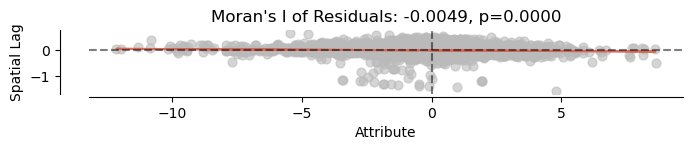

In [ ]:
# =============================================
# MORAN RESIDUALS
# =============================================

fig, ax = moran_scatterplot(error_results["moran"])
ax.set_title(
    f"Moran's I of Residuals: {error_results['moran'].I:.4f}, p={error_results['moran'].p_norm:.4f}"
)
plt.tight_layout()
plt.show()

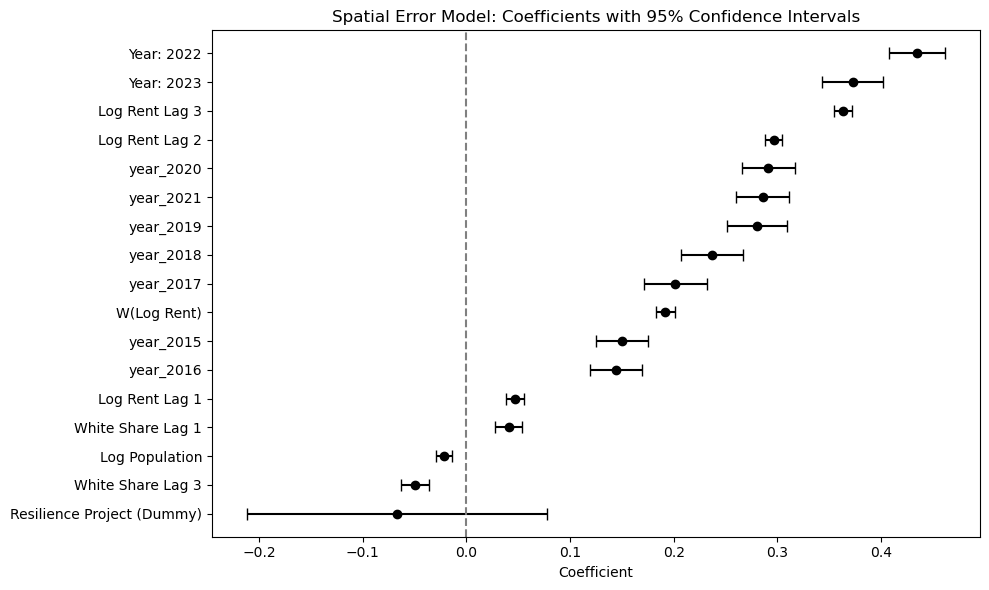

In [ ]:
# =============================================
# COEFFICENT EVALUATION
# =============================================

# Make readable labels for coefficients
label_lookup = {
    "has_resilience_project": "Resilience Project (Dummy)",
    "proj_count": "Number of Resilience Projects",
    "post_project_lag1": "Post-Project Lag 1",
    "post_project_lag2": "Post-Project Lag 2",
    "post_project_lag3": "Post-Project Lag 3",
    "post_project_lag4": "Post-Project Lag 4",
    "post_project_lag5": "Post-Project Lag 5",
    "coastal_treated": "Coastal × Treated",
    "poverty_treated": "Poverty × Treated",
    "race_treated": "White Share × Treated",
    "college_grad_treated": "College Grad × Treated",
    "eviction_pressure_treated": "Eviction Rate × Treated",
    "no_diploma_treated": "No Diploma × Treated",
    "density_treated": "Density × Treated",
    "W_log_rent": "W(Log Rent)",
    "W_poverty_rate": "W(Poverty Rate)",
    "W_coastal_treated": "W(Coastal × Treated)",
    "W_has_resilience_project": "W(Resilience Project)",
    "year_2022": "Year: 2022",
    "year_2023": "Year: 2023",
    "log_rent_lag_1": "Log Rent Lag 1",
    "log_rent_lag_2": "Log Rent Lag 2",
    "log_rent_lag_3": "Log Rent Lag 3",
    "race_white_share_lag_1": "White Share Lag 1",
    "race_white_share_lag_3": "White Share Lag 3",
    "poverty_rate_lag_3": "Poverty Rate Lag 3",
    "log_population": "Log Population",
}

# Extract raw coefficients and standard errors
coef_dict = error_results["coefficients"]
se_array = error_results["model"].std_err.flatten()
name_order = error_results["model"].name_x

# Build records safely
records = []
for i, var in enumerate(name_order):
    if i >= len(se_array):
        break  # avoid index error
    coef = coef_dict.get(var)
    se = se_array[i]
    if coef is not None and se is not None and not pd.isna(se):
        records.append(
            {
                "Variable": label_lookup.get(var, var),
                "Coefficient": coef,
                "SE": se,
                "CI_lower": coef - 1.96 * se,
                "CI_upper": coef + 1.96 * se,
            }
        )

# Create DataFrame
coef_df = pd.DataFrame(records).sort_values("Coefficient")

# Remove 'CONSTANT' row if present
coef_df = coef_df[coef_df["Variable"] != "CONSTANT"]

# Cut out coefficients too close to 0 for interpretability
coef_df = coef_df[coef_df["Coefficient"].abs() > 0.02]

# Sort for plotting
coef_df = coef_df.sort_values("Coefficient")

# Plot
plt.figure(figsize=(10, max(6, len(coef_df) * 0.35)))  # dynamic height
plt.errorbar(
    coef_df["Coefficient"],
    coef_df["Variable"],
    xerr=[
        coef_df["Coefficient"] - coef_df["CI_lower"],
        coef_df["CI_upper"] - coef_df["Coefficient"],
    ],
    fmt="o",
    color="black",
    capsize=4,
)
plt.axvline(x=0, linestyle="--", color="gray")
plt.title("Spatial Error Model: Coefficients with 95% Confidence Intervals")
plt.xlabel("Coefficient")
plt.ylabel("")
plt.tight_layout()
plt.savefig("../output/figures/sem_coefficients.png", dpi=300)
plt.show()

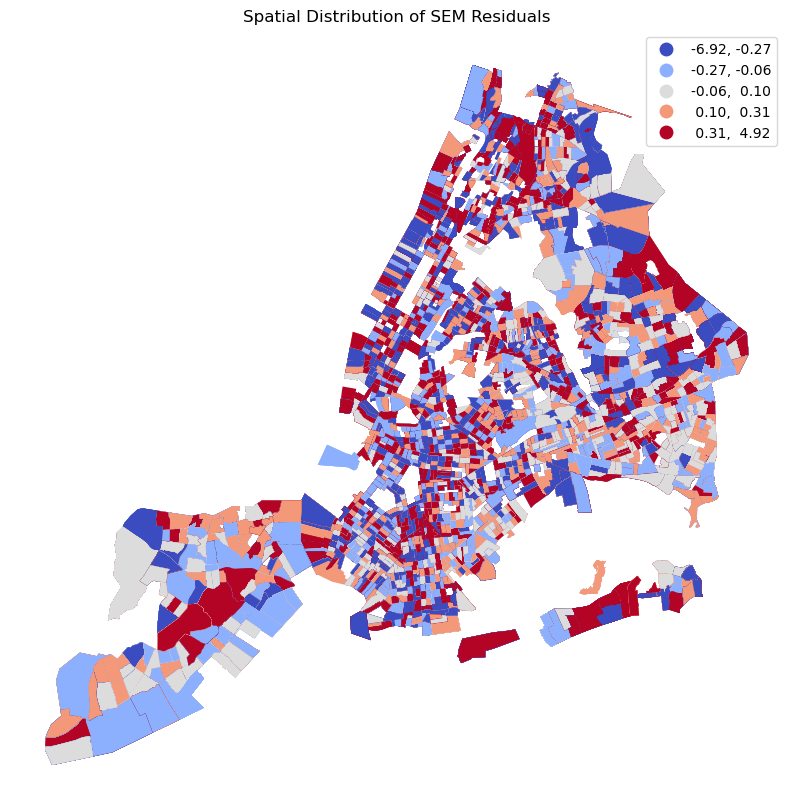

In [ ]:
# =============================================
# Distribution of SEM Residuals
# =============================================

# Assuming `analysis_df_clean` contains geometry and model residuals
analysis_df_standardized["residuals"] = error_results["model"].u
moran = Moran(analysis_df_standardized["residuals"], final_weights)

fig, ax = plt.subplots(figsize=(10, 10))
analysis_df_standardized.plot(
    column="residuals",
    cmap="coolwarm",
    scheme="quantiles",
    k=5,
    legend=True,
    ax=ax,
    edgecolor="none",
)
plt.title("Spatial Distribution of SEM Residuals")
plt.axis("off")
plt.savefig("../output/maps/sem_residuals_map.png", dpi=300, bbox_inches="tight")